# Introduction to DeepTrack2

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/1-getting-started/DTGS101_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeptrack  # Uncomment if running on Colab/Kaggle.

This tutorial gives an overview of how to use DeepTrack2. DeepTrack2 provides a comprehensive framework for digital microscopy enhanced by deep learning. In this tutorial, you'll use the example of tracking a single particle to demonstrate how to effecively use DeepTrack2.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np

## 1. Generating Images

To train and validate deep learning models for digital microscopy, generating synthetic images is an effective approach. For example, these images could resemble the output of a digital video microscopy experiment, where you want to track some particles.

In DeepTrack2, any image can be viewed as a series of **features** applied in a sequence. Each feature takes an input image and updates it according to an **update rule**. For example, a feature can add a particle, introduce some noise, or image something through an optical device.

### Features and properties

In DeepTrack2, these features are classes implementing the class `Feature` (see also [DTAT301_features](../3-advanced-topics/DTAT301_features.ipynb)). The way a feature updates an image is determined by the values passed to the class constructor. These inputs are converted to **properties** (see also [DTAT306_properties](../3-advanced-topics/DTAT306_properties.ipynb)). For example, a property could be the position of a particle. 

For example, the code below creates a feature: a point particle implemented by the class `PointParticle` with properties `position=(0, 0)`, and `intensity=100`. We use `dt.units.pixel` to denote the unit of the property. Most of the time (such as here) this can be omitted.

In [3]:
particle = dt.PointParticle(
    position=(0, 0) * dt.units.pixel,
    intensity=100
)

The above feature is completely deterministic so that the particle will always be at position (0, 0). However, for machine learning, it may be more useful to add a particle at a random position. This can be done by passing a lambda function that returns a pair of random numbers to the property `position`.

In [4]:
IMAGE_SIZE = 64

particle = dt.PointParticle(
    position=lambda: np.random.rand(2) * IMAGE_SIZE * dt.units.pixel,
    intensity=100
)

A point particle on its own does not make much sense when thinking of actual experiments. In order to retrieve an image, you also need to define the optical device through which it is viewed.

In DeepTrack2, **optical devices** are features that convolve the input image with a pupil function. Here, you will use a fluorescence microscope, which is implemented by the feature `Fluorescence` (see also [optics_example](../3-advanced-topics/DTAT323_optics.ipynb)).

In [5]:
fluorescence_microscope = dt.Fluorescence(
    NA=0.8,
    wavelength=680 * dt.units.nm,
    magnification=10,
    resolution=1 * dt.units.micrometer,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE)
)

By calling the fluorescence microscope `fluorescence_microscope` with the point particle `particle`, you create a new feature which resolves the image of the particle as seen through the fluorescence microscope.

In [6]:
imaged_particle = fluorescence_microscope(particle)

You can finally create the image of the particle by calling the feature `imaged_particle()` and plot it.

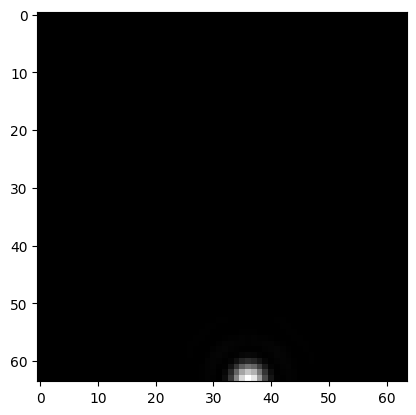

In [7]:
output_image = imaged_particle()

plt.imshow(np.squeeze(output_image), cmap='gray')
plt.show()

As a shorthand for this, you can also call plot on the feature directly.

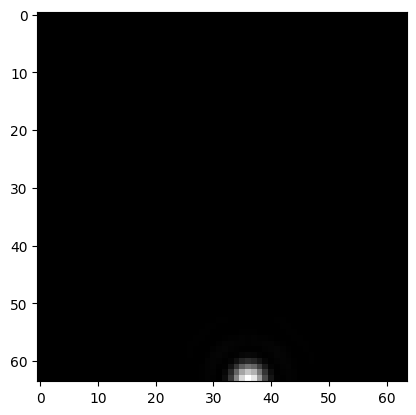

In [8]:
imaged_particle.plot(cmap="gray");

You might have noticed that, even though the position of the particle is random, it doesn't change if you refresh the cell. This is because the value of the particle position is stored as a property of the particle, useful for example to know the ground truth value of the particle position to train a deep-learning model.

If you want the particle position to change each time you refresh the cell, you need to call the method `imaged_particle.update()` before resolving the image.

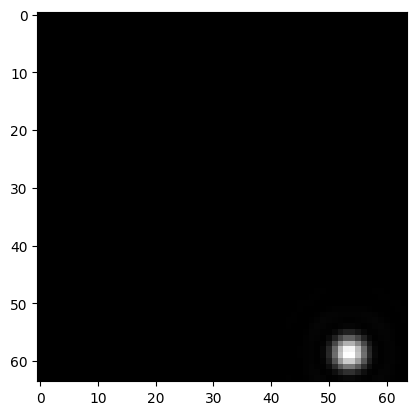

In [9]:
imaged_particle.update().plot(cmap="gray");

### Creating a pipeline

The power of feature is the ability to chain them.

The most common way to chain features is through the pipe operator (`>>`). This will take the output of the feature on the left and pass it as input to the feature on the right. For example, here's how to add noise to the image.

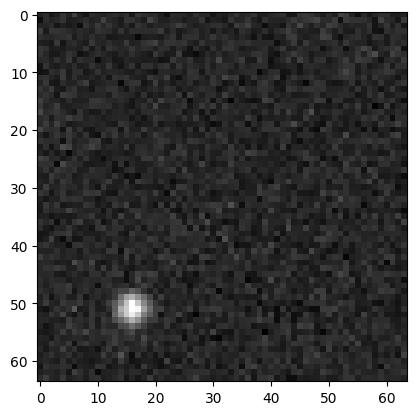

In [10]:
noisy_image = imaged_particle >> dt.Gaussian(sigma=0.01)

noisy_image.update().plot(cmap="gray");

You can also get the properties (for example the `position` property) of a feature by accessing `feature.{propertyname}`. For example, to get the position of the particle, you can call `particle.position`.

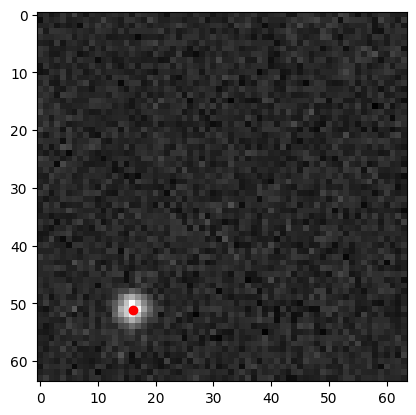

In [11]:
noisy_image_particle_position = dt.Value(particle.position)

image = noisy_image()
position = noisy_image_particle_position()

plt.imshow(np.squeeze(image), cmap="gray")
plt.scatter(position[1], position[0], c="r");

Features can also cleanly interact with things that are not features, such as arithmetic operators or functions.

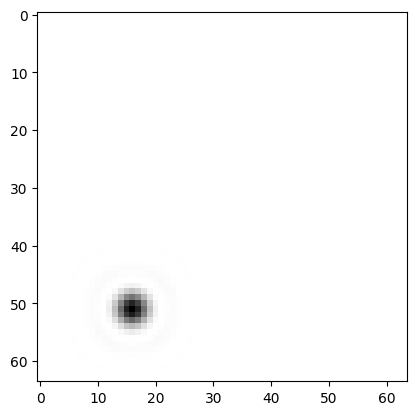

In [12]:
# Arithmetic operator.
inverted_particle = 1 - imaged_particle 
inverted_particle.plot(cmap="gray");

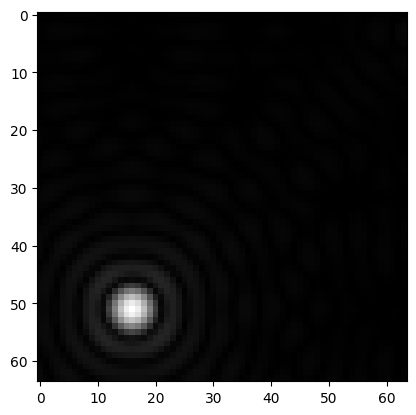

In [13]:
# Function.
sqrt_of_particle = imaged_particle >> np.sqrt
sqrt_of_particle.plot(cmap="gray");

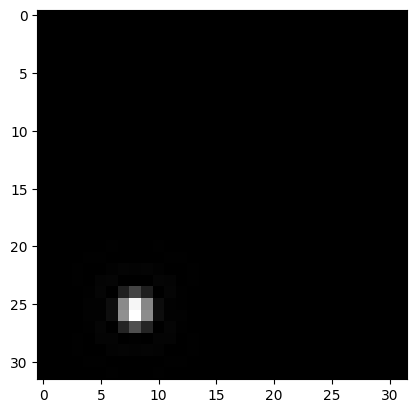

In [14]:
# Indexing operator.
downsampled_particle = imaged_particle[::2, ::2]
downsampled_particle.plot(cmap="gray");

There are also a few special operators, noteably the `^` operator and the `&` operator.

The `^` operator is a handly tool for evaluating a feature multiple times. Note that each time it is evaluated, it will use a new set of properties. As such, it is a very convenient way to resolve multiple particles.

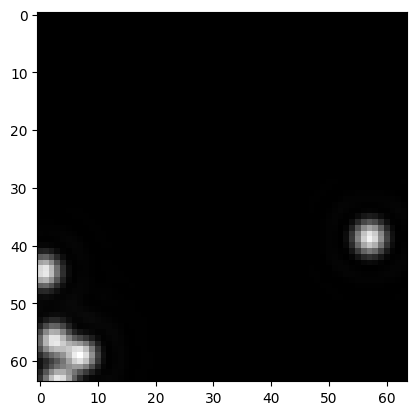

In [15]:
# The ^ operator.

particle = dt.PointParticle(
    position=lambda: (np.random.rand(2) * IMAGE_SIZE),
    intensity=1
)

five_particles = particle ^ 5

imaged_five_particles = fluorescence_microscope(five_particles)

imaged_five_particles.update().plot(cmap="gray");

The `&` will be demonstrated in detail later in this example. But know for now that is a way to stack the outputs of multiple features.

Bringing it all together, you can create a nice experimental image of multiple particles!

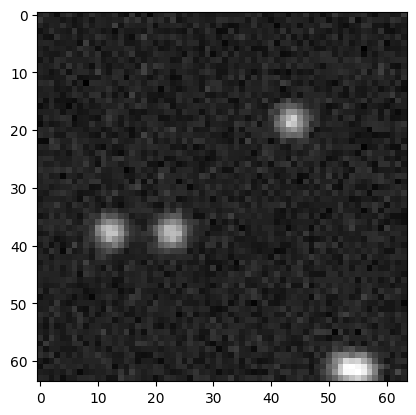

In [16]:
particles = particle ^ 5

experimental_image = (
    fluorescence_microscope(particles) + 0.1 
    >> dt.Poisson(snr=7, background=0.1)
)

experimental_image.update().plot(cmap="gray");

## 2. Retrieving Information about the Image

To train a supervised machine-learning model, often labelled images are needed. You can use the `TakeProperties` feature to extract all positions of the particles in the image. This is useful when there are many instances of the property, such as the position of the many particles in the image.

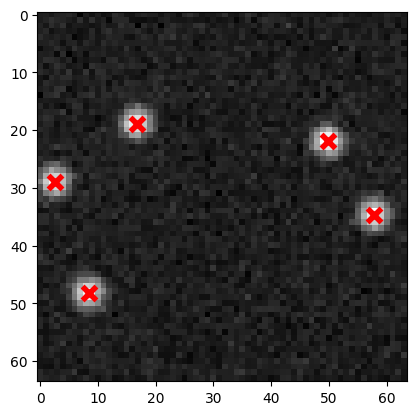

In [17]:
get_positions = dt.TakeProperties(experimental_image, "position")

output_image = experimental_image.update()()  # Update and resolve.

positions = get_positions()  # Returns a list.

plt.imshow(np.squeeze(output_image), cmap="gray")
plt.scatter(positions[:, 1], positions[:, 0],
            c="r", s=100, linewidths=4, marker="x")
plt.show()

Now, you want a pipeline that returns both the image and the positions of the particles at once. For this, you can use the `&` operator.

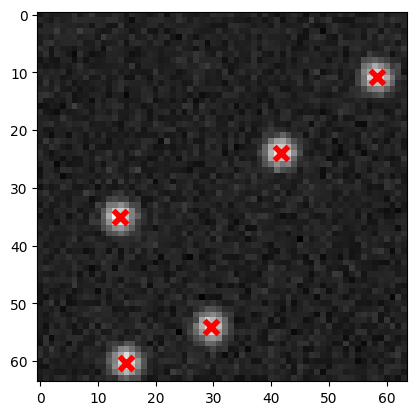

In [18]:
position_feature = dt.TakeProperties(experimental_image, "position")

image_and_position = experimental_image & position_feature

output_image, positions = image_and_position.update()()

plt.imshow(np.squeeze(output_image), cmap="gray")
plt.scatter(positions[:, 1], positions[:, 0],
            c="r", s=100, linewidths=4, marker="x")
plt.show()

Here, you first created a feature that extracts the positions in the image, and then you stacked them using the `&` operator. The result is a feature that first calls `experimental_image()` and then `get_positions(experimental_image())`, and returns both results. DeepTrack2 makes sure that `experimental_image` will not be executed twice unless needed, ensuring the consistency between the image and the positions.

## 3. Training a Neural Network Model

In [19]:
# !pip install deeplay  # Uncomment if running on Colab/Kaggle.

You are finally ready to create a deep-learning model to track the particles. You will use `deeplay`, which is developed by the same team as DeepTrack2. Deeplay is a deep-learning library containing a collection of flexible and modular components for building and training deep-learning models, with a seamless integration with DeepTrack2. 


In [20]:
import deeptrack.deeplay as dl

# Define the neural network model.
net = dl.MultiLayerPerceptron(
    in_features=64 * 64,
    hidden_features=[64, 256],
    out_features=2,
)


# Define a training set.
particle = dt.PointParticle(
    position=lambda: IMAGE_SIZE / 2 + np.random.randn(2) * 2,
)

training_data = fluorescence_microscope(particle) >> dt.NormalizeMinMax()

normalized_position = particle.position - IMAGE_SIZE / 2

training_set = training_data & normalized_position

Next, you need to tell the model which loss and optimizer to use. You can do this by using `dl.Regressor()`, since you are doing a regression task.

In [21]:
model = dl.Regressor(net)

print(model)

Regressor(
  (loss): L1Loss()
  (optimizer): Adam[Adam](lr=0.001)
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=4096, out_features=64, bias=True)
        (activation): Layer[ReLU]()
      )
      (1): LinearBlock(
        (layer): Layer[Linear](in_features=64, out_features=256, bias=True)
        (activation): Layer[ReLU]()
      )
      (2): LinearBlock(
        (layer): Layer[Linear](in_features=256, out_features=2, bias=True)
        (activation): Layer[Identity]()
      )
    )
  )
)


You can now train your neural network model using the `.fit()` method to which you pass the various parameters of the fitting.

Since you have defined the `training_set` as a feature that returns the data and the label simultaneously, you can train the model by passing it the feature directly. Deeplay will make the dataset for us internally. Furthermore, you can easily generate a separate validation set from the same feature.

In [22]:
h = model.fit(
    training_set,
    max_epochs=20,
    batch_size=32, 
    steps_per_epoch=100,
    val_data=training_set,
    val_batch_size=128,
    val_steps_per_epoch=1
)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss               │      0 │ train │
│ 1 │ train_metrics │ MetricCollection     │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection     │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection     │      0 │ train │
│ 4 │ model         │ MultiLayerPerceptron │  279 K │ train │
│ 5 │ optimizer     │ Adam                 │      0 │ train │
└───┴───────────────┴──────────────────────┴────────┴───────┘

Trainable params: 279 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 279 K                                                                                                
Total estimated model params size (MB): 1                                                                          
Modules in train mode: 16                                                                                          
Modules in eval mode: 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_book/lib/python3.10/site-packages/lightning/py
torch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to
improve performance.

You can inspect the output of the `.fit()` method to see how the training went. For example, you can plot the loss to see how it evolved over time.

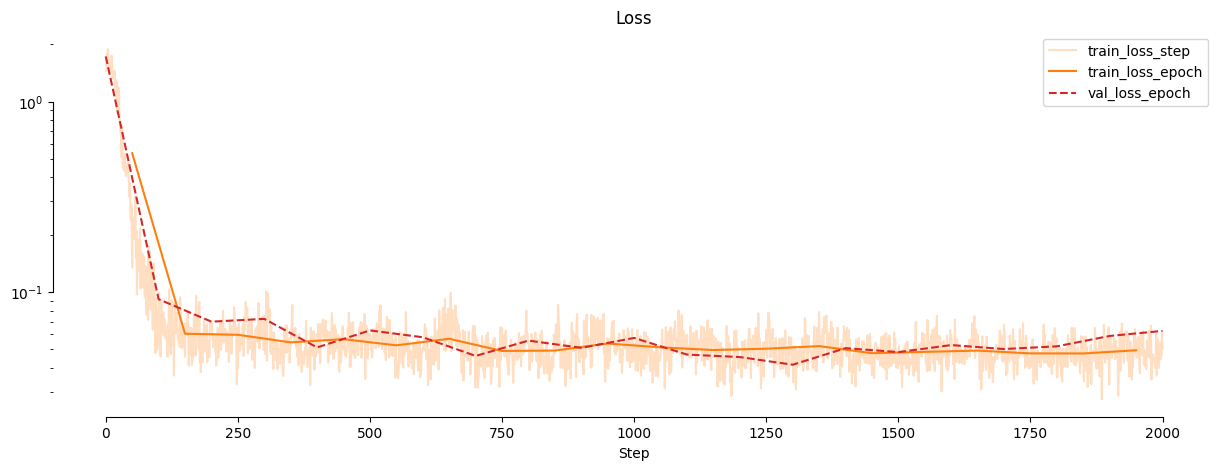

In [23]:
import seaborn as sns

h.plot()
sns.despine(trim=True)

Finally, you can test the trained model on some newly generated images. You can create a batch of data using the `.batch()` method. You also call `.torch()` to convert the data to a format that Deeplay expects.

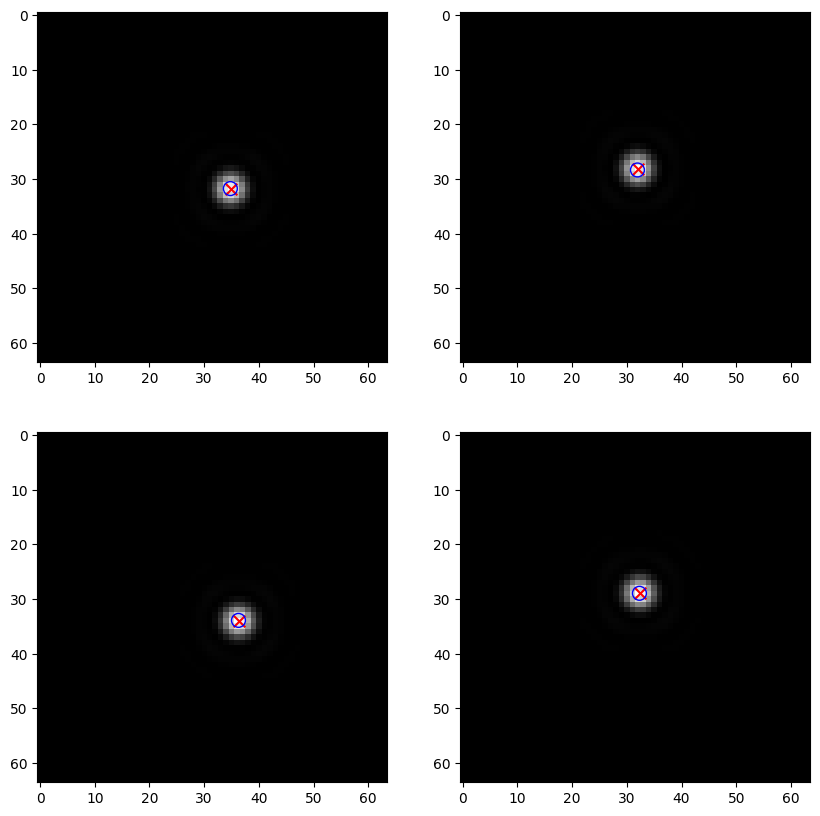

In [24]:
images, true_positions = training_set.batch(4)
estimated_positions = (model.predict(np.array(images).astype(np.float32)) 
                       + IMAGE_SIZE / 2)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for ax, image, true_position, measured_position in zip(ax.ravel(), images, 
                                                       true_positions, 
                                                       estimated_positions):
    ax.imshow(np.squeeze(image), cmap="gray")
    ax.scatter(true_position[1] + IMAGE_SIZE / 2,
               true_position[0] + IMAGE_SIZE / 2,
               s=70, c="r", marker="x")
    ax.scatter(measured_position[1], measured_position[0],
               s=100, marker="o", facecolor="none", edgecolors="b")

plt.show()